In [1]:
'''
The code in this Jupyter Notebook is intended solely to demonstrate the generation of saliency heatmaps. 
Training is performed briefly on the CPU, and the results are for illustrative purposes only.
'''

'\nThe code in this Jupyter Notebook is intended solely to demonstrate the generation of saliency heatmaps. \nTraining is performed briefly on the CPU, and the results are for illustrative purposes only.\n'

In [2]:
import torch
import warnings

warnings.filterwarnings("ignore")
from models.TC import TC
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "0"  #!!
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "0"  #!!
import numpy as np
import random
from models.TC import TC
from models.utils_model import *
from models.pic import PIC_no, PIC_RBP
from data_preprocessing.CRBP.dataloader import data_generator
from models.model import base_Model
from config_files.circrna_configs import Config as Configs
from models.HDRNet import HDRNet

coden_dict = {'AGO1': 0, 'AGO2': 1, 'AGO3': 2, 'ALKBH5': 3, 'AUF1': 4, 'C17ORF85': 5, 'C22ORF28': 6, 'CAPRIN1': 7,
              'DGCR8': 8, 'EIF4A3': 9, 'EWSR1': 10,
              'FMRP': 11, 'FOX2': 12, 'FUS': 13, 'FXR1': 14, 'FXR2': 15, 'HNRNPC': 16, 'HUR': 17, 'IGF2BP1': 18,
              'IGF2BP2': 19, 'IGF2BP3': 20,
              'LIN28A': 21, 'LIN28B': 22, 'METTL3': 23, 'MOV10': 24, 'PTB': 25, 'PUM2': 26, 'QKI': 27, 'SFRS1': 28,
              'TAF15': 29, 'TDP43': 30,
              'TIA1': 31, 'TIAL1': 32, 'TNRC6': 33, 'U2AF65': 34, 'WTAP': 35, 'ZC3H7B': 36,
              }

D:\anaconda3\envs\CRSP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\anaconda3\envs\CRSP\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
data_name = 'WTAP'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
configs = Configs()
model = base_Model(configs).to(device)
temporal_contr_model = TC(configs, device).to(device)

logs_save_dir = 'experiments_logs'
experiment_description = data_name + '_Exp1'
run_description = data_name + 'feature_RBP'
training_mode = 'train_linear'
SEED = 123

experiment_log_dir = os.path.join(logs_save_dir, experiment_description, run_description, training_mode + f"_seed_{SEED}")
checkpoint = torch.load(os.path.join(experiment_log_dir, "saved_models_best", f'ckp_best.pt'))
model.load_state_dict(checkpoint['model_state_dict'])
temporal_contr_model.load_state_dict(checkpoint['temporal_contr_model_state_dict'])

pic_model_NO = PIC_no(configs, device).to(device)
pic_model_RBP = PIC_RBP(configs, device).to(device)
hdrnet = HDRNet()

model.eval()
temporal_contr_model.eval()
pic_model_RBP.eval()
pic_model_NO.eval()

pic_model_RBP

PIC_RBP(
  (Wk): ModuleList(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): Linear(in_features=100, out_features=128, bias=True)
    (2): Linear(in_features=100, out_features=128, bias=True)
    (3): Linear(in_features=100, out_features=128, bias=True)
    (4): Linear(in_features=100, out_features=128, bias=True)
    (5): Linear(in_features=100, out_features=128, bias=True)
    (6): Linear(in_features=100, out_features=128, bias=True)
    (7): Linear(in_features=100, out_features=128, bias=True)
    (8): Linear(in_features=100, out_features=128, bias=True)
    (9): Linear(in_features=100, out_features=128, bias=True)
    (10): Linear(in_features=100, out_features=128, bias=True)
    (11): Linear(in_features=100, out_features=128, bias=True)
    (12): Linear(in_features=100, out_features=128, bias=True)
    (13): Linear(in_features=100, out_features=128, bias=True)
    (14): Linear(in_features=100, out_features=128, bias=True)
    (15): Linear(in_features=100, ou

In [5]:
data_type = data_name

data_path = f"./data/circRNA-RBP/{data_type}"
train_dl, test_dl = data_generator(data_type, configs)

for batch_idx, (data1, data2, data3, data4, data5, labels, idxs) in enumerate(train_dl):

    data1, data2, data3, data4, data5 = data1.float().to(device), data2.float().to(device), data3.float().to(
        device), data4.float().to(device), data5.float().to(device)

    labels = labels.long().to(device)
    # np.savetxt('labels.txt',labels)

    idxs = idxs.long().to(device)

    RBP = np.loadtxt('./rbp_data/37RBP_37_512_5.txt',
                     delimiter=',').reshape((37, 512, 5))

    RBP_PART = RBP[coden_dict[data_type]].reshape((1, 512, 5))  # WTAP

    index = coden_dict[data_type]
    available_indices = list(range(len(coden_dict)))
    available_indices.remove(index)

    RBP_1_index = random.choice(available_indices)
    available_indices.remove(RBP_1_index)

    RBP_2_index = random.choice(available_indices)

    RBP_1 = RBP[RBP_1_index].reshape((1, 512, 5))
    RBP_2 = RBP[RBP_2_index].reshape((1, 512, 5))

    RBP_ten = torch.from_numpy(RBP_PART)
    RBP_ten1 = torch.from_numpy(RBP_1)
    RBP_ten2 = torch.from_numpy(RBP_2)

    dataR = RBP_ten.float()
    data_RBP1 = RBP_ten1.float()
    data_RBP2 = RBP_ten2.float()

    features1 = model(data1, tag=1)
    features2 = model(data2, tag=2)
    features3 = model(data3, tag=3)
    features4 = model(data4, tag=3)

    features5 = model(data5, tag=5)

    # output = hdrnet(features3)

    output = hdrnet(features1, features2, features3, features4)
    # output = hdrnet(features1, features2, features3,features4,features5)

    # output1 = output.detach().numpy()
    # with open('output.txt', 'w') as outfile:
    #     for slice_2d in output1:
    #         np.savetxt(outfile, slice_2d, fmt='%f', delimiter=',')

    RBP_f = model(dataR, tag=4)
    RBP_f1 = model(data_RBP1, tag=4)
    RBP_f2 = model(data_RBP2, tag=4)

    a = features1.size(-1) + features2.size(-1) + features3.size(-1) + features4.size(-1)

    result = torch.zeros(64, 128, a + 5)

    zero_counter = 0
    one_counter = 0

    for idx, label in enumerate(labels):

        if label == 1:

            one_counter += 1
            result[idx, :, :a] = output[idx, :, :]
            result[idx, :, a:] = RBP_f[0, :, :]
        else:
            result[idx, :, :a] = output[idx, :, :]
            if zero_counter % 2 == 0:
                result[idx, :, a:] = RBP_f1[0, :, :]
            else:
                result[idx, :, a:] = RBP_f2[0, :, :]

            zero_counter += 1

In [6]:
data_seq = []
with open('datasets/circRNA-RBP/' + data_type + '/positive') as f:
    for line in f:
        if '>' not in line:
            data_seq.append((line.strip()).replace('T', 'U'))
with open('datasets/circRNA-RBP/' + data_type + '/negative') as f:
    for line in f:
        if '>' not in line:
            data_seq.append((line.strip()).replace('T', 'U'))

data_seq[0], len(data_seq)

('AGAGCGAGCAGAUCCGGGCGCAGGCUGAGGAGAGGAGGAAGACCCUGAGCGAGGAGACCCGGCAGCACCAGGCCGUAAGAGCGCAAGAGGCCGCGAGGGAG',
 892)

In [7]:
import shap
import pandas as pd

torch.cuda.empty_cache()

# print(test_emb)
# e = shap.GradientExplainer(temporal_contr_model,
#                            [test_f1,test_f2,test_f3,test_f4,test_RBP_f,test_RBP_f1,test_RBP_f2,test_output,test_labels])

# e = shap.GradientExplainer(temporal_contr_model,
#                            [test_f1,test_f2,test_f3,test_f4,new_RBP_f,new_RBP_f1,new_RBP_f2,test_output,test_labels])

e = shap.GradientExplainer(pic_model_RBP, [result])
# e = shap.GradientExplainer(pic_model_NO, [output])


i = 0  # Plot which sample number

# Interpretation of individual samples
idx_seq = idxs[i]
# idx_seq = 274

# shap_values = e.shap_values([test_f1[i:i+1], test_f2[i:i+1],test_f3[i:i+1],test_f4[i:i+1],new_RBP_f[i:i+1],new_RBP_f1[i:i+1],new_RBP_f2[i:i+1],test_output[i:i+1],test_labels[i:i+1]])

shap_values = e.shap_values([result[i:i + 1]])
# shap_values = e.shap_values([output[i:i + 1]])  # Calculate SHAP values for specified samples

# shap_values = e.shap_values([test_f1[i:i+1], test_f2[i:i+1],test_f3[i:i+1],test_f4[i:i+1]])
# shap_values = e.shap_values([a,test_RBP_f,test_RBP_f1,test_RBP_f2,test_output[i:i+1]])

# input_seq = sequences[i]

input_seq = data_seq[idx_seq]

# input_struct = test_struc[i]

bert_attention_data = np.max(shap_values[0], axis=1)
# bert_attention_data = np.max(shap_values[1], axis=1)

# Create a new array to store the processed bert attention data
new_bert_attention_data = np.zeros((1, 101))
for j in range(101):
    if j == 0:
        new_bert_attention_data[0, j] = bert_attention_data[0, j]
    elif j == 1:
        new_bert_attention_data[0, j] = (bert_attention_data[0, j - 1] + bert_attention_data[0, j]) / 2
    elif j == 99:
        new_bert_attention_data[0, j] = (bert_attention_data[0, j - 1] + bert_attention_data[0, j - 2]) / 2
    elif j == 100:
        new_bert_attention_data[0, j] = bert_attention_data[0, j - 2]
    else:
        new_bert_attention_data[0, j] = (bert_attention_data[0, j - 2] + bert_attention_data[0, j - 1] +
                                         bert_attention_data[0, j]) / 3

bert_attention_data = new_bert_attention_data
# The processed BERT attention data is combined with the input sequence data
bert_attention_data = convert_one_hot2([input_seq], bert_attention_data[0, :]).transpose(1, 0, 2).squeeze()
#
#
# struc_attention_data = shap_values[1][0]

#
# Concatenate BERT attention data and structural attention data
W = bert_attention_data

onehot = convert_one_hot([input_seq]).squeeze()
X = onehot
#
# X = np.concatenate([onehot, input_struct.cpu().detach().numpy()], axis=0)

idxs, idx_seq, input_seq

# df = pd.DataFrame(data) #, columns=sss)

(tensor([500, 518,  12, 836, 817, 756, 771, 409,  89, 467, 847, 116, 201, 570,
         814, 464,  70, 214, 192, 807, 661,  41, 283, 531, 402, 392, 349, 296,
         778, 851, 658, 752, 657, 857, 400,  90, 494, 875, 512, 326, 102, 530,
         795,  35, 859, 306,  11,  28, 325, 420, 665, 380, 278, 613, 830,   6,
         815, 355, 650, 154, 137,  92, 622, 485]),
 tensor(500),
 'GGGCGGGGGAGUUGAAACUCCCUUCUAUCUAGGACUCUCUCGGGACACCUCCACAUCGAUUCUUUUUGUUUGUUUUUUUGAGAUGGAAUCUUGAUCUGUUG')

In [8]:
# Plot the salience map of the selected sample
import models.visualize as visualize

# visualize.plot_saliency(X, W, nt_width=100, norm_factor=3, str_null=str_null, outdir="results/high_attention_region_plot/out4.png")
visualize.plot_saliency(X, W, nt_width=100, norm_factor=3, str_null=None, outdir="pic/test.png")

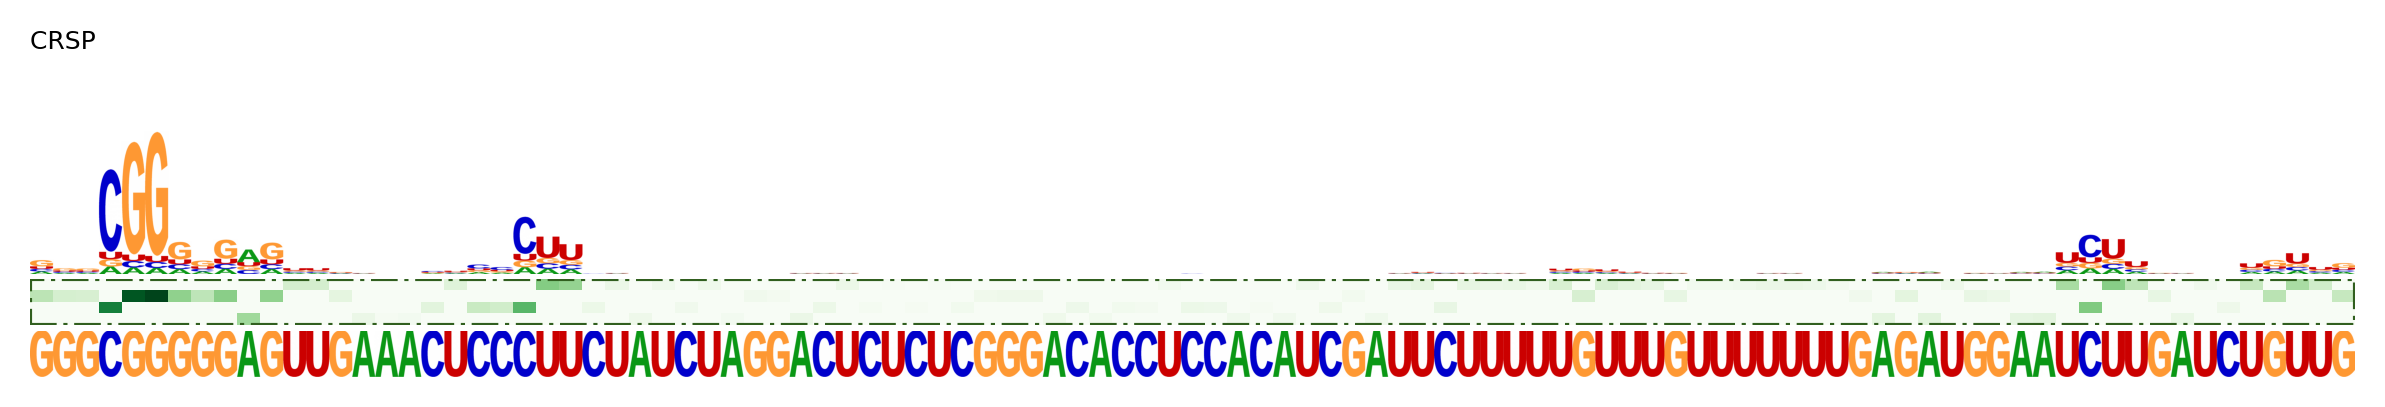

In [9]:
from IPython.display import Image, display

img_path = "pic/test.png"

# 显示图片
display(Image(filename=img_path))